2025-01-22 18:38:15,128 - INFO - Cargando y procesando datos desde /Users/daniel/Desktop/bot/trading-bot/src/data/data.csv en bloques de 100000 filas...
2025-01-22 18:38:15,245 - INFO - Procesando un nuevo bloque...
2025-01-22 18:38:15,381 - INFO - Procesando un nuevo bloque...
2025-01-22 18:38:15,690 - INFO - Procesando un nuevo bloque...
2025-01-22 18:38:15,857 - INFO - Procesando un nuevo bloque...
2025-01-22 18:38:15,983 - INFO - Procesando un nuevo bloque...
2025-01-22 18:38:16,117 - INFO - Procesando un nuevo bloque...
2025-01-22 18:38:16,423 - INFO - Procesando un nuevo bloque...
2025-01-22 18:38:16,563 - INFO - Procesando un nuevo bloque...
2025-01-22 18:38:16,703 - INFO - Procesando un nuevo bloque...
2025-01-22 18:38:16,842 - INFO - Procesando un nuevo bloque...
2025-01-22 18:38:16,988 - INFO - Procesando un nuevo bloque...
2025-01-22 18:38:17,132 - INFO - Procesando un nuevo bloque...
2025-01-22 18:38:17,284 - INFO - Procesando un nuevo bloque...
2025-01-22 18:38:17,525 - IN

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20657045 entries, 2024-01-15 02:00:00.287000 to 2025-01-15 01:59:57.014000
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Bid     float64
 1   Ask     float64
 2   Volume  int64  
dtypes: float64(2), int64(1)
memory usage: 630.4 MB
                             Bid      Ask   Volume
DateTime                                          
2024-01-15 02:00:00.287  1.09451  1.09453  4500000
2024-01-15 02:00:00.390  1.09450  1.09453  5400000
2024-01-15 02:00:00.645  1.09451  1.09453   900000
2024-01-15 02:00:01.050  1.09450  1.09453  4500000
2024-01-15 02:00:02.059  1.09451  1.09453  3600000
Señales de compra activadas:
                             Bid      Ask   Volume     close  signal  \
DateTime                                                               
2024-11-12 18:40:21.179  1.05999  1.06001  7650000  1.060000       0   
2024-11-12 18:40:22.889  1.05999  1.06001  7470000  1.060000       0   
2024-11-1

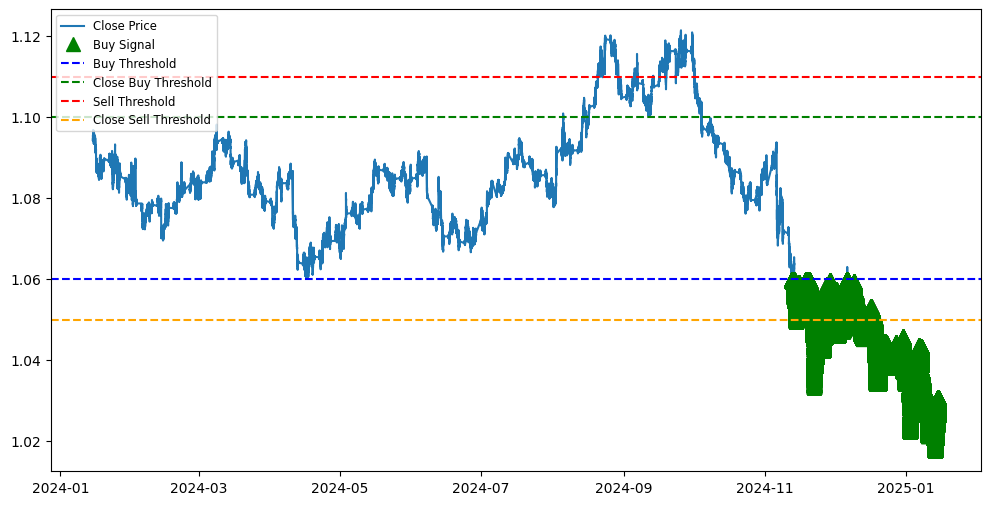

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import logging
from datetime import datetime

# Configuración de los logs
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

class BaseStrategy:
    def __init__(self):
        pass

    def execute_trade(self, signal):
        raise NotImplementedError("Este método debe ser implementado por estrategias específicas.")

    def get_signal(self, market_data):
        raise NotImplementedError("Este método debe ser implementado por estrategias específicas.")

class ThresholdStrategy(BaseStrategy):
    def __init__(self, buy_threshold=1.06451, sell_threshold=1.7):
        self.buy_threshold = buy_threshold
        self.sell_threshold = sell_threshold

    def get_signal(self, market_data):
        market_data['signal'] = 0
        tolerance = 0.0005 # Ajusta la tolerancia según lo necesario
        market_data['buy_signal'] = ((market_data['close'] >= self.buy_threshold - tolerance) & 
                                     (market_data['close'] <= self.buy_threshold + tolerance)).astype(int)
        market_data['sell_signal'] = ((market_data['close'] >= self.sell_threshold - tolerance) & 
                                      (market_data['close'] <= self.sell_threshold + tolerance)).astype(int)
        return market_data

    def execute_trade(self, signal):
        if signal == 1:
            print("Ejecutar compra")
        elif signal == -1:
            print("Ejecutar venta")
        else:
            print("Mantener posición")


def load_and_process_data(file_path, chunksize=10000):
    try:
        logger.info(f"Cargando y procesando datos desde {file_path} en bloques de {chunksize} filas...")

        # DataFrame final para almacenar los resultados procesados
        all_data = pd.DataFrame()
        error_count = 0  # Contador de filas con errores

        # Leer el archivo CSV en bloques
        for chunk in pd.read_csv(
            file_path,
            header=0,  # Asumimos que el archivo CSV tiene encabezados
            names=["DateTime", "Bid", "Ask", "Volume"],
            dtype={"DateTime": str, "Bid": float, "Ask": float, "Volume": int},  # Especificar tipos de datos
            chunksize=chunksize,
            low_memory=False
        ):
            logger.info("Procesando un nuevo bloque...")

            # Convertir la columna 'DateTime' a tipo datetime
            chunk['DateTime'] = pd.to_datetime(chunk['DateTime'], format='%Y%m%d %H:%M:%S.%f', errors='coerce')

            # Filtrar filas con valores inválidos o NaN
            chunk = chunk.dropna()

            # Concatenar el bloque procesado al DataFrame final
            all_data = pd.concat([all_data, chunk], ignore_index=True)

        # Configurar la columna 'DateTime' como índice
        all_data.set_index('DateTime', inplace=True)

        logger.info("Datos cargados y procesados correctamente.")
        logger.info(f"Total de filas con errores: {error_count}")
        return all_data

    except Exception as e:
        logger.error(f"Error al procesar los datos: {e}")
        return None

def test_strategy(strategy, market_data):
    signals = strategy.get_signal(market_data)

    # Mostrar todas las veces que se hubiese activado la compra y venta 
    sell_signals = signals[signals['sell_signal'] == 1]
    print("Señales de venta activadas:")
    print(sell_signals[['close', 'sell_signal']])
    buy_signals = signals[signals['buy_signal'] == 1]
    print("Señales de compra activadas:")
    print(buy_signals[['close', 'buy_signal']])

    # Muestrear los datos para reducir el tamaño
    sampled_data = market_data.iloc[::10, :]  # Ajusta el paso según sea necesario

    # Visualizar los datos y las señales
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=sampled_data.index, y=sampled_data['close'], mode='lines', name='Close Price'))
    fig.add_trace(go.Scatter(x=buy_signals.index, y=buy_signals['close'], mode='markers', marker=dict(color='green', size=10), name='Buy Signal'))
    fig.add_trace(go.Scatter(x=sell_signals.index, y=sell_signals['close'], mode='markers', marker=dict(color='red', size=10), name='Sell Signal'))

    fig.update_layout(title='Señales de Compra y Venta', xaxis_title='Fecha', yaxis_title='Precio de Cierre')
    fig.show()

# Ruta al archivo CSV (actualiza esta ruta según tu sistema)
file_path = '/Users/daniel/Desktop/bot/trading-bot/src/data/data.csv'

# Procesar el archivo
data = load_and_process_data(file_path, chunksize=100000)

if data is not None:
    logger.info(data.info())
    print(data.head())

    # Crear una estrategia y probarla
    strategy = ThresholdStrategy()

    # Crear datos simulados para pruebas si no hay columna 'close'
    if 'close' not in data.columns:
        data['close'] = (data['Bid'] + data['Ask']) / 2

    test_strategy(strategy, data)
else:
    logger.error("No se generó ningún DataFrame procesado.")